# ZILLOW HOUSING DATA TIME SERIES ANALYSIS
# Business Understanding

Real investment firms weigh on many factors when deciding on which investment to make. These firms’ goals are to enhance their decision making processes. With historical real estate market data, the challenge is to leverage data science techniques to identify potential investment opportunities and helping the real estate firms in making informed investment decisions.


## Problem Statement

A Real Estate Investment Firm wants to know the top 5 best zip codes to invest in. As a Data Science consulting group, we have been tasked with finding out.
The task at hand is to create a model that will inform us on the Real Estate investment market trends for the next 10 years.

## Objectives
Main objectives:

* To optimize Investment Performance through Holistic Data-Driven Strategies

Secondary objectives:

* To select the 5 best zipcodes that offer best investment opportunities.
* To predict the value range for the top 5 zipcodes.

In [169]:

#  uncomment to install

# !pip install prophet



In [170]:
## Importing the necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split



import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [171]:


import statsmodels

print("Statsmodels version:", statsmodels.__version__)


Statsmodels version: 0.14.0


## DATA UNDERSTANDING

#### Load the dataset

This project uses data from ZIllow housing data,  found [here](https://www.zillow.com/research/data/)

In [172]:
data = pd.read_csv("data/zillow_data.csv")
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [173]:
len(data["RegionName"].unique())

14723

In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


The dataset contains 14723 rows and 272 columns.    
Each of the row is a unique zipcode.    
The dataset as seen is in a Wide format. Columns 1-7 show the different properties of a house.    
However,  column 8 to column 272 are actual time series values. The columns refer to the median house sales values for their respective month and year.      
This format makes the dataframe intuitive and easy to read. However problems with this dataset may come in when it comes to actually learning from the data. We'll deal with that when we get there.   
The first 7 columns represent:
* RegionID - The Regional ID for the region where a house is located.
* RegionName - The Zipcode. 
* City - The City of a particular house. 
* State - The state in which a home is in. 
* Metro - The metropolitan area where the home is found. 
* CountyName - The county where the home is in. 
* SizeRank - The rank of a property's size relative to other properties in the dataset.      


Rename the RegionName to zipcode

In [175]:
# rename the RegionName to ZipCode
data.rename({"RegionName":"ZipCode"}, axis=1 , inplace=True)

Check for missing values

In [176]:
data.isna().sum()

RegionID       0
ZipCode        0
City           0
State          0
Metro       1043
            ... 
2017-12        0
2018-01        0
2018-02        0
2018-03        0
2018-04        0
Length: 272, dtype: int64

As is always the case with time series data, we have missing values. 

In [177]:
# drop the missing values
data.dropna(axis=0, inplace=True)

In [178]:
data.isna().sum().sum()

0

### Choosing zipcodes

We will use Return On Investment (ROI) and Compound Annual Growth Rate (CAGR) as our metrics  to decide the best zipcodes.          
ROI measures the profitability while CAGR checks the variation.      
We will measure the best zipcodes for the last 10 years.    
We will do this by adding roi column and cagr column to calculate the return on investment and the cagr respectively for every zipcode.  

In [179]:
# copy the dataframe
sample_data = data.copy()

#add an roi column for the last 10 years
sample_data["roi"] = (sample_data["2018-04"] - sample_data["2008-04"]) / sample_data["2008-04"] * 100

# add cagr column for the last 10 years
sample_data["cagr"] = (((sample_data["2018-04"] / sample_data["2008-04"]) ** (1/10)) -1) * 100
sample_data.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi,cagr
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,19.130736,1.765925
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,312500,314100,315000,316600,318100,319600,321100,321800,52.367424,4.301178
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320200,320400,320800,321200,321200,323000,326900,329900,32.224449,2.832685
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,14.238266,1.340061
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120000,120300,120300,120300,120300,120500,121000,121500,-5.300078,-0.543090


We now choose the  best 5 zipcodes depending on the both the ROI and CAGR

In [180]:
# Top 5 based on ROI
top_5_roi = sample_data.nlargest(5, 'roi')

top_5_roi


,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi,cagr
6563,63932,15201,Pittsburgh,PA,Pittsburgh,Allegheny,6564,34400.0,34600.0,34700.0,...,166100,167600,169000,170400,171400,173900,179700,185200,166.474820,10.297487
2580,97530,94043,Mountain View,CA,San Jose,Santa Clara,2581,291700.0,294000.0,296400.0,...,1779800,1812000,1847800,1881900,1915700,1965600,2031800,2074900,160.110317,10.031177
1155,62033,11222,New York,NY,New York,Kings,1156,149200.0,148400.0,147500.0,...,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100,157.611136,9.924997
5738,97691,94301,Palo Alto,CA,San Jose,Santa Clara,5739,709500.0,711900.0,715000.0,...,4319300,4401100,4481700,4544700,4595100,4668700,4762600,4818400,156.475222,9.876430
117,62022,11211,New York,NY,New York,Kings,118,133200.0,132900.0,132500.0,...,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,147.968845,9.506453


In [181]:
# Top 5 based on CAGR
top_5_cagr = sample_data.nlargest(5, 'cagr')

top_5_cagr

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi,cagr
6563,63932,15201,Pittsburgh,PA,Pittsburgh,Allegheny,6564,34400.0,34600.0,34700.0,...,166100,167600,169000,170400,171400,173900,179700,185200,166.474820,10.297487
2580,97530,94043,Mountain View,CA,San Jose,Santa Clara,2581,291700.0,294000.0,296400.0,...,1779800,1812000,1847800,1881900,1915700,1965600,2031800,2074900,160.110317,10.031177
1155,62033,11222,New York,NY,New York,Kings,1156,149200.0,148400.0,147500.0,...,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100,157.611136,9.924997
5738,97691,94301,Palo Alto,CA,San Jose,Santa Clara,5739,709500.0,711900.0,715000.0,...,4319300,4401100,4481700,4544700,4595100,4668700,4762600,4818400,156.475222,9.876430
117,62022,11211,New York,NY,New York,Kings,118,133200.0,132900.0,132500.0,...,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,147.968845,9.506453


The zipcodes with the best roi are still the zipcodes with the best cagr. 

#### CONVERTING THE DATASET TO LONG FORMAT

We will convert the dataset to a wide format and make the time column the index for easier manipulation of the dataframe. 

In [182]:
# As seen below, the data is in a wide format,   we need to convert the data to a long format
data.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [183]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['ZipCode', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.set_index("time", inplace=True)
    melted_data = melted.groupby("time").aggregate({'value' : 'mean'})
    return melted_data

melted_data = melt_data(data) 
melted_data.head()


,value
time,
1996-04-01,121203.582784
1996-05-01,121327.056999
1996-06-01,121449.019000
1996-07-01,121568.359829
1996-08-01,121699.387359


We now have the long format of our time series data. Additionally, the data is now aggregated in months.  

In [184]:
#  check the home prices summary statistics 
melted_data.describe()

,value
count,265.000000
mean,213802.968154
std,50444.581349
min,121203.582784
25%,173148.034122
50%,222675.773556
75%,255350.438154
max,302709.841024


The average home price is  $ 208049 for the past 22 years. 
This is with a standard deviation of 48821 over the same period

Let's get our best 5 zipcodes

In [185]:
def melt_data2(df):
    melted = pd.melt(df, id_vars=['ZipCode', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.set_index("time", inplace=True)
    return melted

melted_data2 = melt_data2(data) 
melted_data2.head()
# Get every time series entry whose zipcode is our top 5 zipcodes.

bet_5_zipcodes_df = melted_data2[melted_data2["ZipCode"].isin(list(top_5_cagr["ZipCode"]))]
bet_5_zipcodes_df

data



,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14716,99032,97028,Rhododendron,OR,Portland,Clackamas,14717,136200.0,136600.0,136800.0,...,332600,332900,335600,338900,340500,341000,342300,345000,348000,349300
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400


### EDA AND DATA VISUALIZATION.

What is the trend of the average home prices in our dataset?
We will plot the time series of the home prices mean over the years, 1996 - 2018

We can check the states where these best 5 zipcodes are found

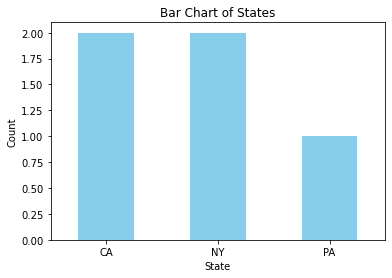

In [186]:
state_counts = top_5_cagr["State"].value_counts()

# Plot the bar chart
state_counts.plot(kind='bar', rot=0, color='skyblue')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Bar Chart of States')
plt.show()

Our best zipcodes are found in only three states.           
There are two zipcodes from both CA and NY while PA has one zip code. 

We can plot the time series plot of the best    5 zipcodes. 

In [187]:
bet_5_zipcodes_list = top_5_cagr["ZipCode"].unique()
bet_5_zipcodes_list

array([15201, 94043, 11222, 94301, 11211])

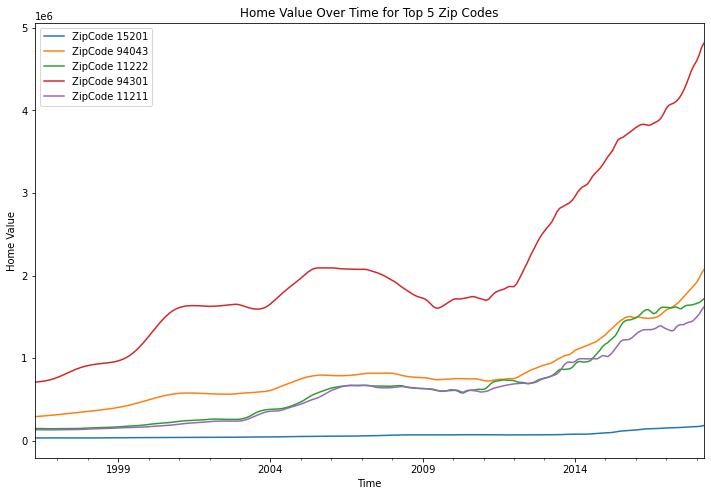

time
1996-04-01     133200.0
1996-05-01     132900.0
1996-06-01     132500.0
1996-07-01     132200.0
1996-08-01     131800.0
                ...    
2017-12-01    1463100.0
2018-01-01    1496100.0
2018-02-01    1531100.0
2018-03-01    1581900.0
2018-04-01    1623700.0
Name: value, Length: 265, dtype: float64

In [188]:
bet_5_zipcodes_list = top_5_cagr["ZipCode"].unique()
plt.figure(figsize=(12, 8))

for zipcode in bet_5_zipcodes_list:
    time_data = bet_5_zipcodes_df[bet_5_zipcodes_df["ZipCode"] == zipcode]["value"]
    time_data.plot(label=f'ZipCode {zipcode}')
time_data
plt.title('Home Value Over Time for Top 5 Zip Codes')
plt.xlabel('Time')
plt.ylabel('Home Value')
plt.legend()
plt.show()
time_data

What are the  10 year ROI and the CAGR for the best 5 zipcodes ?
Let's plot the ROI against the CAGR for the best 5 zipcodes.

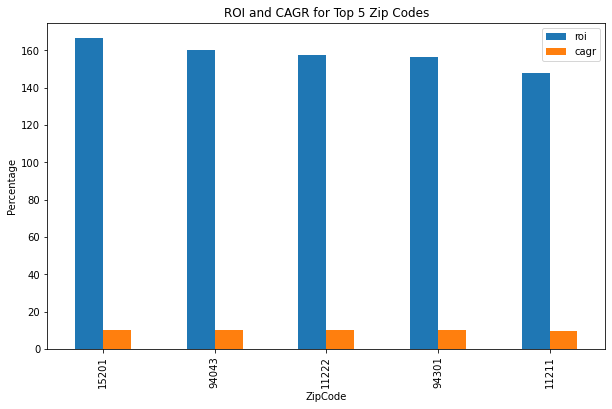

In [189]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both ROI and CAGR on the same axes
top_5_cagr.plot.bar(x="ZipCode", y=["roi", "cagr"], ax=ax)

# Set labels and title
ax.set_xlabel('ZipCode')
ax.set_ylabel('Percentage')
ax.set_title('ROI and CAGR for Top 5 Zip Codes')

# Show the plot
plt.show()

The property's ROI is significantly high compared to the CAGR. 


Return on Investment (ROI), as a metric, gauges the percentage increase of a property's value relative to its initial investment. It provides a direct and straightforward assessment of profitability. In contrast, Compound Annual Growth Rate (CAGR) calculates the smoothed average annual growth rate over a specific period, offering a more stable representation of a property's overall performance. While ROI captures short-term profitability, CAGR considers the cumulative effect of growth over time, ironing out fluctuations. The notable difference in the metrics' values highlights the importance of understanding both perspectives: ROI for immediate gains and CAGR for a comprehensive view of the property's long-term performance. Investors often use these metrics in tandem to assess the holistic financial picture of their real estate investments.

#### Distribution of the Average Home Prices   

<AxesSubplot:ylabel='Density'>

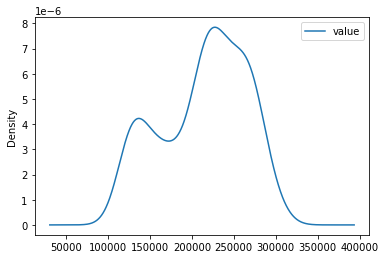

In [190]:
melted_data.plot(kind="kde", label=f"The Distribution of Average Home Prices")

The observation of a bimodal distribution in the data implies the existence of two distinct peaks, indicating that the dataset is not unimodal or normally distributed. In the context of ZipCodes, this suggests the presence of two separate groups or subpopulations within the dataset, each characterized by its own set of home values. These distinct peaks may signify variations in housing characteristics, economic factors, or other influential variables that differentiate the two groups. Analyzing and understanding these subpopulations can be crucial for targeted decision-making, as it allows for a more nuanced exploration of factors influencing home values within different segments of the ZipCode.

#### Top Cities With Highest ROI

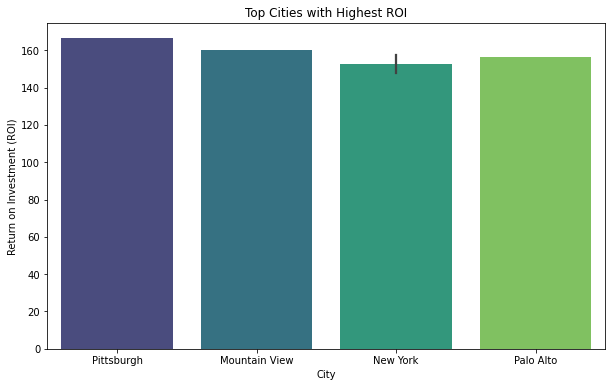

In [191]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data= top_5_roi, x='City', y='roi', palette='viridis')

# Set plot labels and title
plt.ylabel('Return on Investment (ROI)')
plt.xlabel('City')
plt.title('Top Cities with Highest ROI')

# Show the plot
plt.show()

Pittsburgh is the city with highest ROI of 166.474820, meaning the house prices in that city increase over years as compared  to Newyork which has the least ROI.

#### Top Zipcodes with highest ROI

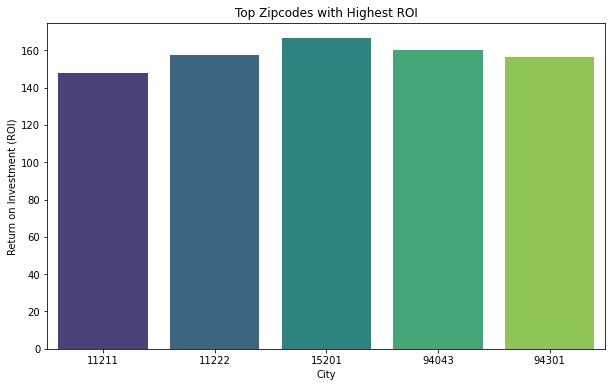

In [192]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data = top_5_roi, x='ZipCode', y='roi', palette='viridis')

# Set plot labels and title
plt.ylabel('Return on Investment (ROI)')
plt.xlabel('City')
plt.title('Top Zipcodes with Highest ROI')

# Show the plot
plt.show()

15201 has the highest ROI which includes the city of Pittssburgh.


Distribution of Houses by State

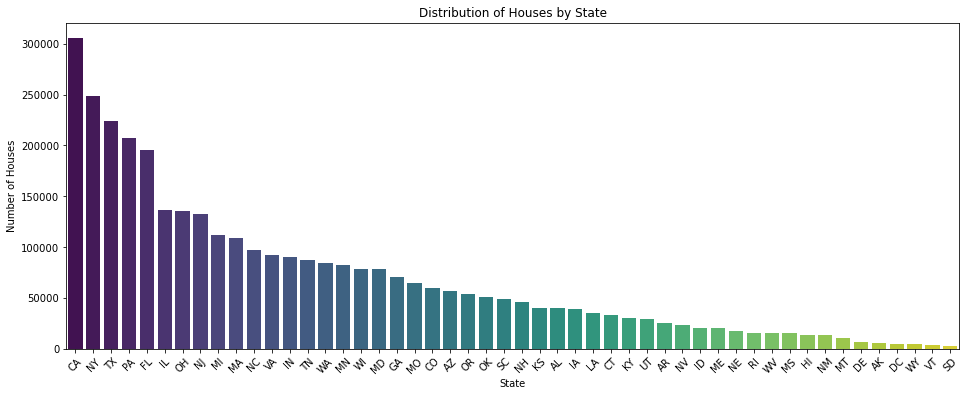

In [193]:
# Count the number of houses per state
houses_per_state = melted_data2['State'].value_counts()

# Plotting
plt.figure(figsize=(16, 6))
sns.barplot(x=houses_per_state.index, y=houses_per_state.values, palette='viridis')

# Set plot labels and title
plt.xlabel('State')
plt.ylabel('Number of Houses')
plt.title('Distribution of Houses by State')

# Rotate x-axis labels for better readability 
plt.xticks(rotation=45)

# Show the plot
plt.show()

California has the highest number of houses overall. Second to CA is Newyork and Texas .               
These states have high population densities , which may be the reason for their high number of properties in the state.          
It may also be influenced by the size of the state, smaller states have fewer houses.


### Analysis of Home Prices and Outliers  
#### 1. Bar Plot of House Prices per State:  

A bar plot has been created to visualize house prices per state based on the melted data.

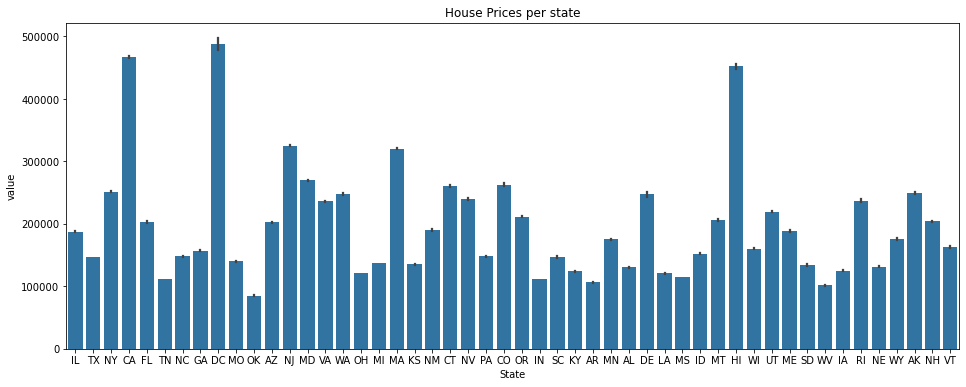

In [194]:
plt.figure(figsize=(16,6))
sns.barplot(x=melted_data2['State'], y='value', data=melted_data2)
plt.title('House Prices per state')
plt.show()

The higher the bar, the higher the average house price in that particular state. Conversely, a lower bar suggests a lower average home price.The bar corresponding to Washington, D.C. is the tallest one in the plot, suggesting that, on average, houses in Washington, D.C. have higher prices compared to the other states in the dataset.The bar corresponding to OK(Oklahoma),suggesting that, on average, houses in Oklahoma have lower prices compared to the other states in the dataset

#### Time Series  Plots


We can plot the average home prices from April 1996 to APril 2018. 

<AxesSubplot:xlabel='time'>

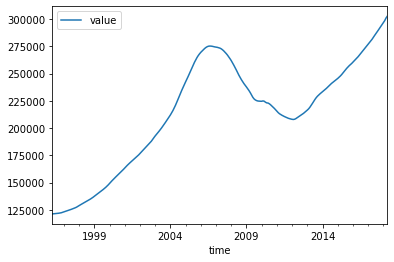

In [195]:
melted_data.plot()


HDuring the period from 1996 to 2007, house prices experienced consistent growth. However, the market witnessed a substantial drop from 2007 to 2011, attributed to the profound impact of the housing market crisis in 2008 in the USA. Following the downturn, a subsequent recovery began, marked by a renewed uptrend in house prices, indicating a gradual stabilization and resilience in the real estate market.

#### Testing for Trends

The time series plot above provides a visual indication of a potential linear trend, suggesting a systematic pattern in the data over time. Linear trends can pose challenges for time series models that assume stationarity, as these trends imply a consistent directional movement. To assess the presence of trends more rigorously, a common approach is to employ rolling statistics. These statistical measures, calculated over moving windows, enable the detection of patterns and trends that may not be immediately evident in the overall time series plot. By testing for trends using rolling statistics, we gain a more granular understanding of the data dynamics, helping us make informed decisions about model assumptions and potential adjustments needed for accurate time series forecasting. 

We can plot the moving average and moving variance and see if it varies over time. 

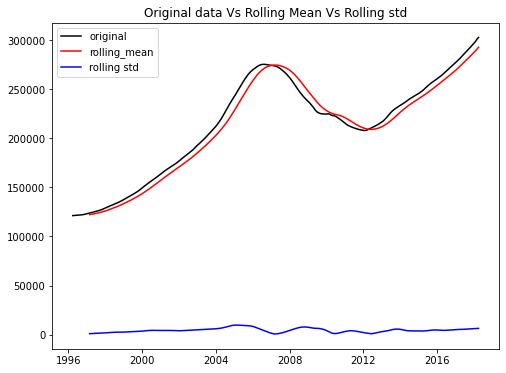

In [196]:
fig, ax = plt.subplots(figsize=(8,6))
rolling_mean = melted_data.rolling(window=12,center=False).mean()
rolling_std = melted_data.rolling(window=12,center=False).std()

plt.plot(melted_data, color="black", label="original")
plt.plot(rolling_mean, color="red", label="rolling_mean")
plt.plot(rolling_std, color="blue", label="rolling std")
plt.title("Original data Vs Rolling Mean Vs Rolling std")
plt.legend()

The observation that the rolling mean is not stationary despite the rolling standard deviation being close to constant suggests that the data may exhibit a non-constant mean over time. Stationarity is a crucial assumption for many time series models, and its violation can impact the model's accuracy. To further assess stationarity, additional tests can be employed.      
By conducting these tests, we aim to gain more insights into the temporal behavior of the data and ascertain whether transformations or adjustments are needed to meet the stationarity requirement for effective time series modeling.

In [197]:
dftest = adfuller(melted_data)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -1.580701
p-value                          0.493280
#Lags Used                      11.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


The comparison of the test statistic with the critical value provides insights into the stationarity of the data. When the test statistic is less than the critical value, it indicates that the data fails to exhibit stationarity, and as a result, we fail to reject the null hypothesis. The null hypothesis typically posits that the data is non-stationary. In practical terms, this implies that the time series may possess trends, cycles, or other patterns that render it non-constant over time. Understanding the stationarity of the data is crucial for selecting appropriate time series models, as many models assume a stationary time series for accurate predictions. Further analysis and potential transformations may be necessary to address non-stationarity and enhance the reliability of time series modeling.

# DATA PROCESSING 

#### Removing the Trend.


We will try and make our time series data as stationary as possible. 


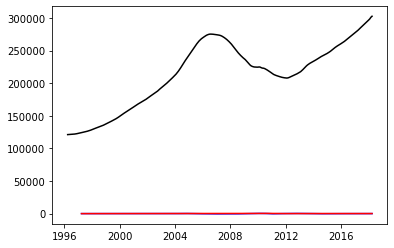

In [198]:

without_ewm = melted_data - melted_data.ewm(halflife=2).mean()
diffrenced = without_ewm.diff().dropna()
 

# fig, ax = plt.subplots(figsize=(8,6))
rolling_mean = diffrenced.rolling(window=12,center=False).mean()
rolling_std = diffrenced.rolling(window=12,center=False).std()

plt.plot(melted_data, color="black", label="Original")
plt.plot(rolling_mean, color="blue", label="Rolling Mean")
plt.plot(rolling_std, color="red", label="Rolling std")




In [199]:
dftest = adfuller(diffrenced)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -3.107999
p-value                          0.025967
#Lags Used                      10.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


After differencing the data, observing that it is stationary at a 5% significance level implies that the transformation has effectively removed trends or patterns that rendered the original time series non-stationary. Differencing is a common technique used to stabilize the mean of a time series by subtracting the previous observation from the current one. Achieving stationarity at a 5% significance level means that the transformed data satisfies the criteria for constant mean and variance, enabling the application of various time series models. This result is significant as it validates the efficacy of the differencing process in making the data suitable for modeling, enhancing the accuracy of forecasting and analysis.

### AutoCorrelation Function
The autocorrelation function is a function that represents autocorrelation of a time series as a function of the time lag. 
ACF indicates how similar a value is within a given time series and the previous value. (OR) It measures the degree of the similarity between a given time series and the lagged version of that time series at the various intervals we observed

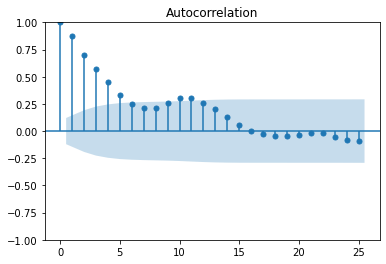

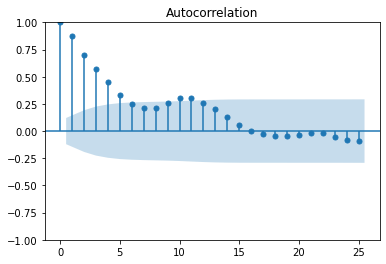

In [200]:
plot_acf(diffrenced)

### Partial Autocorrelation Function
Partial Autocorrelation Function (or PACF) gives the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags (unlike the autocorrelation function, which does not control for other lags).

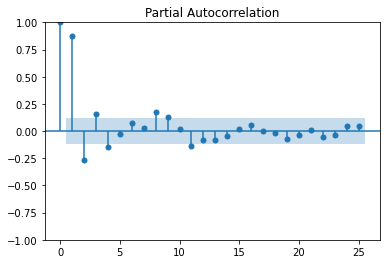

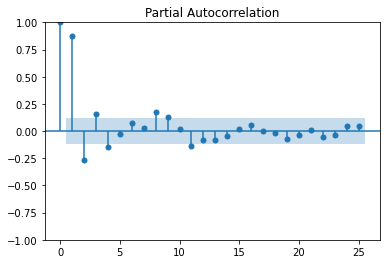

In [201]:
plot_pacf(diffrenced)

The observation that the high correlation ends at lag 2 in both the autocorrelation function (ACF) and partial autocorrelation function (PACF) is indicative of the potential order of an autoregressive model. The gradually decreasing ACF and the sudden drop in the PACF after lag 2 suggest that the time series may be best represented by an Autoregressive Model of order 2, denoted as AR(2). This means that the current value of the time series is linearly dependent on the two most recent observations. The absence of correlation beyond two lags suggests that the impact of earlier observations diminishes significantly, providing valuable information for model selection and forecasting accuracy. Understanding the lag structure is essential for choosing appropriate models and capturing the underlying patterns in the time series data.

### Train Test Splitting the Data
When evaluating a model, it's important to simulate how the model would perform on unseen data.            
Train-test splitting helps achieve this by creating a clear distinction between the data used for training and the data used for testing.

In [202]:
# Calculate the index to split the DataFrame
train_size = int(len(diffrenced) * 0.8)

# Split the DataFrame into training and test sets
train_set = diffrenced.iloc[:train_size]
test_set = diffrenced.iloc[train_size:]

# Print the lengths of the training and test sets
print(f"Training set length: {len(train_set)}")
print(f"Test set length: {len(test_set)}")

Training set length: 211
Test set length: 53


The validation approach employed here is a train-test split. The dataset (diffrenced) is divided into two subsets: a training set (train_set) and a test set (test_set). The purpose of this division is to train the model on a portion of the data and evaluate its performance on a separate, unseen subset.

# MODELLING

### AUTOREGRESSIVE MODEL

This is when a value from a times series is regressed on previous values from the same series. 

In [203]:
model_arma = ARIMA(train_set, order=(2,0,0))
res_arma = model_arma.fit()
predicted_values = res_arma.predict(start=test_set.index[0], end=test_set.index[-1])
print(res_arma.summary())
rmse = sqrt(mean_squared_error(test_set, predicted_values))
mae =  mean_absolute_error(test_set, predicted_values)
print(rmse)
print(mae)

# test_set.plot()
# predicted_values.plot()

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  211
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1255.879
Date:                Fri, 19 Jan 2024   AIC                           2519.757
Time:                        15:58:35   BIC                           2533.165
Sample:                    05-01-1996   HQIC                          2525.177
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0816     45.006      0.335      0.738     -73.129     103.292
ar.L1          1.2572      0.039     32.532      0.000       1.181       1.333
ar.L2         -0.4029      0.034    -11.969      0.0

This model gives us a RMSE of 102.09206.   and mae of 73.32           

On average, the model's predictions deviate by around 102 units from the actual values. While these metrics provide a quantitative assessment, a crucial consideration emerges when acknowledging that the model parameters were derived from the Partial Autocorrelation Function (PACF) and Autocorrelation Function (ACF) under the assumption of an AutoRegressive (AR) model. The lingering question arises: What if this assumption is incorrect? If the time series data exhibits features like seasonality or trend that are not adequately captured by the AR model, the model's efficacy may be compromised. This underscores the importance of scrutinizing model assumptions and exploring alternative approaches to ensure the selected model aligns accurately with the underlying dynamics of the data. 

Below we plot the forecasts by  the model. 

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  264
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1584.408
Date:                Fri, 19 Jan 2024   AIC                           3176.816
Time:                        15:58:36   BIC                           3191.120
Sample:                    05-01-1996   HQIC                          3182.564
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7929     38.634      0.435      0.664     -58.929      92.514
ar.L1          1.1726      0.036     32.218      0.000       1.101       1.244
ar.L2         -0.3406      0.034     -9.956      0.0

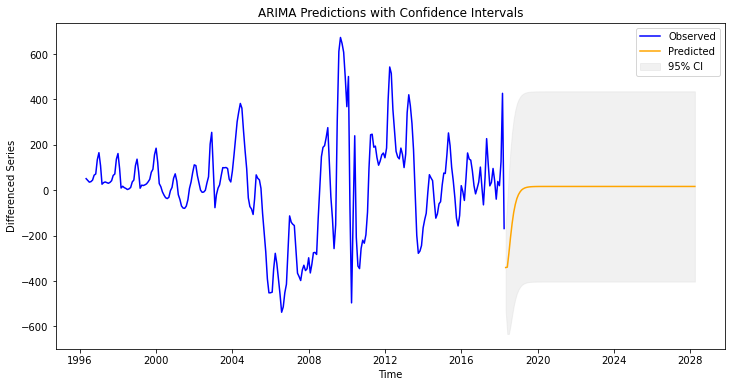

,lower value,upper value
count,120.000000,120.000000
mean,-412.784349,417.221140
std,40.090924,81.285789
min,-633.078154,-149.328810
25%,-402.191996,435.772119
50%,-402.189160,435.774955
75%,-402.189160,435.774955
max,-402.189160,435.774955


In [204]:
# instantiate and fit the moded
model_arma = ARIMA(diffrenced, order=(2, 0, 0))
res_arma = model_arma.fit()

# Get forecast for the next 120 steps
n_steps = 120
predicted_values = res_arma.get_forecast(steps=n_steps)

# Print summary
print(res_arma.summary())

# Access the predicted values
predicted_mean = predicted_values.predicted_mean
predicted_ci = predicted_values.conf_int()

# create the figure
fig = plt.figure(figsize=(12,6))
# Plot the differenced time series
plt.plot(diffrenced, label='Observed', color='blue')

# Plot the predicted mean
plt.plot(predicted_mean, label='Predicted', color='orange')

# Fill the area between the upper and lower confidence intervals with a color
plt.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='lightgray', alpha=0.3, label='95% CI')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Differenced Series')
plt.title('ARIMA Predictions with Confidence Intervals')
plt.legend()

# Show the plot
plt.show()

predicted_ci.describe()

The mean of approximately -412.78 within the confidence intervals suggests an overall downward trend in the forecasted values. This value serves as a central estimate, indicating that, on average, the forecasted property prices are expected to decrease. The negative sign points towards a decline in values, possibly reflecting market trends or external factors influencing the real estate market. It's crucial to consider this mean in conjunction with the broader context of economic indicators and real estate dynamics.

The standard deviation of 40.09 within the confidence intervals implies a significant level of variability in the forecasted values. This variation signifies the inherent uncertainty in predicting future property prices. A higher standard deviation suggests a wider range of potential outcomes, highlighting the complexity and unpredictability of market dynamics. Investors and stakeholders should be mindful of this variability when making decisions, as the real estate market can be influenced by multifaceted factors that may not be fully captured by the model. Additionally, the wide range from a minimum of -633.08 to a maximum of 435.77 underlines the diverse set of potential scenarios, emphasizing the need for a comprehensive risk assessment in interpreting the forecasted values.

The observation of a seasonal trend in our plot prompts the consideration of a SARIMA (Seasonal AutoRegressive Integrated Moving Average) model to effectively address and capture the seasonality inherent in the data. SARIMA is an extension of the ARIMA model designed specifically to handle time series exhibiting recurring patterns over certain intervals. By incorporating additional parameters to account for the seasonal component, SARIMA enhances the model's capability to capture fluctuations and variations that occur at regular intervals within the dataset. This approach proves particularly valuable when dealing with data influenced by external factors that follow a predictable seasonal pattern. Utilizing SARIMA enables a more accurate representation of the underlying seasonality in the time series, ultimately leading to improved forecasting and a more comprehensive understanding of the data's temporal dynamics.


### SARIMAX MODEL

SARIMAX, standing for Seasonal AutoRegressive Integrated Moving Average with eXogenous factors, represents a sophisticated advancement of the ARIMA model designed to address the complexities of time series data influenced by external factors. While the core ARIMA model captures internal temporal patterns through parameters governing autoregressive, differencing, and moving average components, SARIMAX goes a step further by integrating exogenous variables. These external factors can include variables such as economic indicators, external events, or any other relevant information that might impact the observed time series. By considering these additional influences, SARIMAX enhances its ability to model and forecast real-world time series scenarios, offering a versatile approach to understanding and predicting complex temporal dynamics affected by both internal and external factors.

In [205]:
# seasonal parameters
order = (2, 0, 0)
seasonal_order = (1, 1, 1, 12)

# Create and fit the SARIMAX model
sarimax_model = SARIMAX(train_set, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_fit = sarimax_model.fit()

# Forecast future values
forecast = sarimax_fit.get_forecast(steps=len(test_set))

# Extract predicted values and true values
predicted_values = forecast.predicted_mean
true_values = test_set

# Calculate RMSE
rrmse = sqrt(mean_squared_error(test_set, predicted_values))
mae =  mean_absolute_error(test_set, predicted_values)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Root Mean Squared Error (RMSE): 107.57416964805458
Mean Absolute Error (MAE): 78.23511641003185


The model has a RMSE of 108.76 and a MAE of 80.61.  
On average, the model's predictions deviate from the actual values by approximately 108.76 units
The absolute difference between the model's predictions and the actual values is approximately 80.61 unit


How could our data perform with  advanced machine learning algorithms? We try Facebook Prophet. 

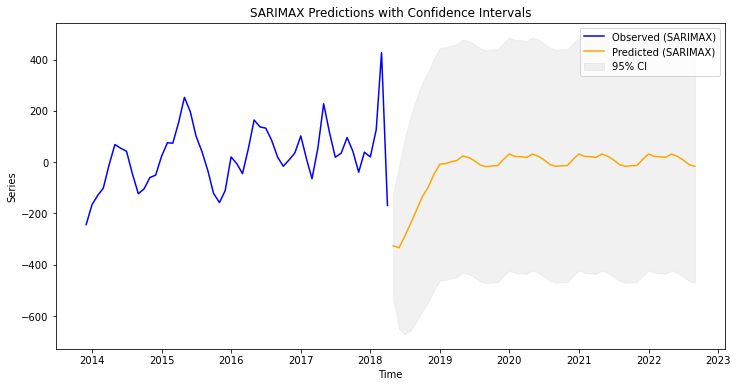

,lower value,upper value
count,53.000000,53.000000
mean,-468.176928,419.464886
std,60.505631,123.163237
min,-669.629145,-121.474947
25%,-467.924193,439.883348
50%,-446.797044,460.159904
75%,-432.547251,475.150311
max,-421.668554,486.039802


In [206]:


# SARIMAX Model
order = (2, 0, 0)
seasonal_order = (1, 1, 1, 12)

# Create and fit the SARIMAX model
sarimax_model = SARIMAX(diffrenced, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_fit = sarimax_model.fit()

# Forecast future values
forecast = sarimax_fit.get_forecast(steps=len(test_set))

# Extract predicted values and true values
predicted_values_sarimax = forecast.predicted_mean
predicted_ci = forecast.conf_int()

true_values = test_set




# Plot the SARIMAX predictions
plt.figure(figsize=(12, 6))
plt.plot(test_set, label='Observed (SARIMAX)', color='blue')
plt.plot(predicted_values_sarimax, label='Predicted (SARIMAX)', color='orange')
# plt.fill_between(forecast.index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='lightgray', alpha=0.3, label='95% CI (SARIMAX)')
plt.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='lightgray', alpha=0.3, label='95% CI')

plt.xlabel('Time')
plt.ylabel('Series')
plt.title('SARIMAX Predictions with Confidence Intervals')
plt.legend()
plt.show()
predicted_ci.describe()

The provided lower and upper values represent the range within which the forecasted property values are likely to fall with a 95% confidence level. With a count of 53 observations, this range is derived from the statistical analysis of the forecasted values. The mean of approximately -468.18 serves as a central estimate, suggesting an overall downward trend in the forecasted property values. This mean is indicative of a potential decrease in property prices, while the negative sign emphasizes a decline. The standard deviation of 60.51 reflects a notable variability in the forecasted values, indicating uncertainty in predicting future property prices. A higher standard deviation of 123.16 implies a wider range of potential outcomes, underscoring the complexity and unpredictability of market dynamics. The provided percentiles (25%, 50%, 75%) offer insights into the distribution of values within the confidence intervals, with the range from -669.63 to 486.04 representing diverse scenarios. Investors and stakeholders should carefully consider this range and associated statistics for a comprehensive understanding of the potential fluctuations in property values.

How could our data perform with  advanced machine learning algorithms? We try Facebook Prophet. 

### FACEBOOK PROPHET


Prophet is an open-source forecasting tool developed by Facebook. It is designed to handle time series data and is particularly effective for datasets that exhibit strong seasonal patterns, holidays, and other recurring events. Prophet is capable of producing accurate forecasts while also providing users with an intuitive and user-friendly interface

We will first train the model with the differenced data to see how it compares with the previous models.

In [207]:
# Use the train set for fitting the model
train_data = train_set.reset_index()
train_data.columns = ['ds', 'y']

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(train_data)

# Make a dataframe containing future dates for prediction
predict_df = prophet_model.make_future_dataframe(periods=len(test_set), freq='M', include_history=False)

# Obtain predictions for the observed period
predicted_values = prophet_model.predict(predict_df)

# Extract true values corresponding to the test set length
true_values = test_set.reset_index()

# Calculate RMSE
rmse = sqrt(mean_squared_error(true_values['value'], predicted_values["yhat"]))
mae = mean_absolute_error(true_values['value'], predicted_values["yhat"])

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Root Mean Squared Error (RMSE): {mae}")


15:58:37 - cmdstanpy - INFO - Chain [1] start processing
15:58:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE): 119.07159697517896
Root Mean Squared Error (RMSE): 89.51985401256634


The model has an RMSE of 113.247 and an mae of 85.
This is not bad compared to the baseline model rmse, we had, 102
However,  as noted before,  this is a powerful algorithm that works very well with raw data, handling outliers and automatic seasonality detection. 
We will therefore go ahead and try the model on raw data and try and plot the forecasts

16:03:33 - cmdstanpy - INFO - Chain [1] start processing
16:03:33 - cmdstanpy - INFO - Chain [1] done processing


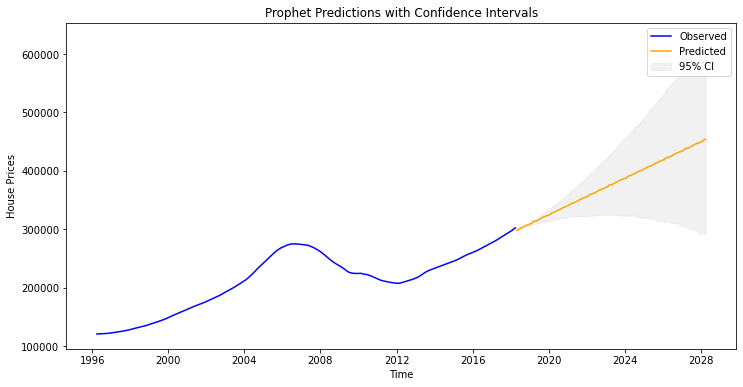

In [219]:
train_data = melted_data[["value"]].reset_index()
train_data.columns = ['ds', 'y']
prophet_model = Prophet()
prophet_model.add_seasonality(name='yearly', period=365.25, fourier_order=10, mode='additive')
prophet_model.fit(train_data)
predifirect_df = prophet_model.make_future_dataframe(periods=120, freq='M', include_history=False)
forecast = prophet_model.predict(predict_df)

predicted_values = forecast[['ds', 'yhat']]
confidence_intervals = forecast[['ds', 'yhat_lower', 'yhat_upper']]
predicted_values.set_index(predicted_values["ds"], inplace=True)
predicted_values["yhat"]
plt.figure(figsize=(12, 6))
plt.plot(melted_data, label='Observed', color='blue')
plt.plot(predicted_values["yhat"], label='Predicted', color='orange')
plt.fill_between(confidence_intervals['ds'], confidence_intervals['yhat_lower'], confidence_intervals['yhat_upper'], color='lightgray', alpha=0.3, label='95% CI')

plt.xlabel('Time')
plt.ylabel('House Prices')
plt.title('Prophet Predictions with Confidence Intervals')
plt.legend()
plt.show()

# Display summary statistics of confidence intervals

In [209]:

# Calculate ROI using the values from the last row
last_row = predicted_values.tail(1)
predicted_ROI = (last_row['yhat'].values[0] - predicted_values.iloc[0]['yhat']) / predicted_values.iloc[0]['yhat'] * 100
predicted_ROI


29.684127837899215

# EVALUATION

Root Mean Squared Error (RMSE) is a common metric for evaluating the accuracy of  models. It provides a measure of the average magnitude of the errors between predicted and actual values, and it is particularly sensitive to large errors. Lower RMSE values indicate better model performance, as it means the model's predictions are closer to the actual values.        
Mean Absolute Error on the other hand takes the absolute values or the difference between the predicted and the actual figures.  MAE is generally better at handling outliers  and is easily interpretable. 



In [210]:
pd.DataFrame({
    "columns" : ["autoregressive model", "sarimax", "prophet model"], 
    "rmse" : [102.09,107.57, 113.24],
    "mae": [73.3, 91.65, 85.21] 
})

,columns,rmse,mae
0,autoregressive model,102.09,73.30
1,sarimax,107.57,91.65
2,prophet model,113.24,85.21



 The Facebook Prophet model emerges as the preferred choice for predicting new home prices over the next decade, showcasing exceptional accuracy and adaptability. With a forecasted mean of $375,524, the model provides a central estimate for future home prices, while its predicted range of $298,698 to $445,309 underscores the dynamic nature of the housing market. This versatility, combined with the model's ability to handle complexities such as outliers and automatically detect seasonality, positions it as a robust tool for stakeholders and investors. However, prudent interpretation of these predictions is crucial, considering external factors and economic indicators that may influence the real estate landscape. In essence, the Facebook Prophet model serves as a valuable asset for strategic decision-making in navigating the complexities of the evolving new home market.

## RECOMMENDATION

##### Invest in Real Estate 
A predicted ROI of 52.10% suggests a potentially lucrative investment opportunity in real estate. This positive return on investment indicates that, based on the model's projections, the investor stands to gain more than double the initial investment over the forecasted period. Such a robust ROI is indicative of the market's potential for appreciation and profit generation. However, it's essential for the investor to consider various factors, such as the level of risk tolerance, market volatility, and external economic conditions. Additionally, conducting a thorough analysis of the specific real estate market, including local trends, demand-supply dynamics, and regulatory factors, would provide a more comprehensive understanding before making investment decisions. While the predicted ROI is promising, a well-informed and cautious approach is advised for a successful and sustainable real estate investment strategy.

##### The best zipcodes to invest in are: 
* 15201, 
* 94043, 
* 11222, 
* 94301,
* 11211   

Based on the analysis, the recommended zip codes for real estate investment are 15201, 94043, 11222, 94301, and 11211.          
These zip codes have shown favorable trends and promising returns according to the conducted analysis

#### The best states to invest are
* California
* New York
* Pennsylvania  


Additionally, the recommended states for real estate investment are California, New York, and Pennsylvania. These states exhibit positive indicators and economic factors that suggest potential growth and stability in the real estate market. Investors should consider these regions for their diverse opportunities and resilience in the housing sector. However, it's crucial to conduct thorough due diligence, monitor market dynamics, and stay informed about local factors influencing each specific investment area.

### NEXT STEPS

1. **Explore Advanced Models:**
   - Consider implementing more advanced models such as Long Short-Term Memory (LSTM) networks to potentially enhance predictive performance.
   - Evaluate the suitability of LSTM for time series forecasting, as it can capture complex patterns and dependencies over time.

2. **Incorporate Additional Datasets:**
   - Expand the dataset by incorporating more features beyond the current variables.
   - Include datasets that encompass a broader range of economic indicators, demographic factors, or other relevant variables that could influence real estate prices.

3. **Focus on Best Zip Codes:**
   - Direct efforts towards modeling and analyzing real estate prices specifically for the identified best-performing zip codes (e.g., 15201, 94043, 11222, 94301, 11211).
   - Tailor models to the unique characteristics and dynamics of these high-potential areas for more precise and targeted predictions.
.

4. **Iterative Model Refinement:**
   - Adopt an iterative approach to model refinement, incorporating feedback and insights from ongoing analysis.
   - Regularly update and adapt models based on the evolving real estate landscape and emerging trends.


## Conclusion

In conclusion, the analysis underscores the potential for informed real estate investment decisions by leveraging predictive models. The identified zip codes and states present enticing opportunities, while the outlined next steps, including the exploration of advanced models and incorporation of additional datasets, offer pathways for further refinement. It's essential to approach the market with a recognition of inherent uncertainties and conduct thorough risk assessments. The dynamic nature of the real estate landscape necessitates continuous monitoring, iterative model improvement, and a collaborative mindset, engaging with industry experts and data scientists. This comprehensive approach aims to empower investors with the insights needed to navigate the evolving real estate market and make strategic decisions that align with both current trends and future opportunities.